# NSGA2 Generator
This notebook demonstrates the use of the generator `NSGA2Generator` which implements the NSGA-II algorithm from [1]. We show how to set up the optimizer object, use it to solve a test problem, and show off some of the generator's output features. Running this notebook will generate files in a temporary directory on your computer. These files will be cleaned up at the end.

In [1]:
import json
import logging
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import tempfile

from xopt.generators.ga.nsga2 import NSGA2Generator, PolynomialMutation, SimulatedBinaryCrossover
from xopt.resources.test_functions.zdt import construct_zdt
from xopt import Xopt, Evaluator

In [2]:
# The NSGA2Generator object emits logger messages
# Configure the logging module to output them to console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Format for log messages
    datefmt='%Y-%m-%d %H:%M:%S'  # Date/time format
)

In [3]:
# Get the problem ZDT2 and create an Xopt evaluator
prob_vocs, prob_fun, _ = construct_zdt(30, 3)
ev = Evaluator(function=prob_fun)

### Generator Setup and Use
First we create the `NSGA2Generator` object, demonstrate some of its settings, and then use it to solve the ZDT3 test problem.

In [4]:
# Create the NSGA2 generator with default settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
)

# Let's demonstrate controlling the generator's hyperparameters and settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
    population_size=50,  # How many individuals in a population
    mutation_operator=PolynomialMutation(pm=1/30, eta_m=20),  # Can manually specify mutation operator and hyperparameters
    crossover_operator=SimulatedBinaryCrossover(delta_1=0.5, delta_2=0.5, eta_c=20),  # Similarly can specify crossover manually
    deduplicate_output=True,  # Performs deduplication of candidate individuals. Ensure unique outputs from generator.
)

2025-03-02 18:40:41 - xopt.generator - INFO - Initialized generator nsga2
2025-03-02 18:40:41 - xopt.generator - INFO - Initialized generator nsga2


In [5]:
# Run the optimizer for a few generations. Notice log output printed below this cell
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)

for _ in range(3):
    X.step()

2025-03-02 18:40:41 - xopt.base - INFO - Running Xopt step
2025-03-02 18:40:41 - xopt.generators.deduplicated - INFO - generated 50 candidates in 2.50ms (removed 0 duplicate individuals)
2025-03-02 18:40:41 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 18:40:41 - xopt.generators.ga.nsga2 - INFO - completed generation 1 in 0.023s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=50, n_candidates=50)
2025-03-02 18:40:41 - xopt.base - INFO - Running Xopt step
2025-03-02 18:40:41 - xopt.generators.deduplicated - INFO - generated 50 candidates in 14.41ms (removed 0 duplicate individuals)
2025-03-02 18:40:41 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 18:40:41 - xopt.generators.ga.nsga2 - INFO - completed generation 2 in 0.027s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=100, n_candidates=100)
2025-03-02 18:40:41

### Exploring Optimizer Output
We now take a look at the metadata associated with the optimizer run as well as its output.

In [6]:
%%time
# Run for longer with log output turned off
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

for _ in range(47):
    X.step()

CPU times: total: 828 ms
Wall time: 930 ms


In [7]:
# Inspect generator properties
print(f"Saw {generator.fevals} function evaluations")  # Number of function evaluations returned to generator
print(f"Completed {generator.n_generations} generations")  # Number of generations finished
print(f"Generated {generator.n_candidates} candidate solutions")  # Number of individuals generated

Saw 2500 function evaluations
Completed 50 generations
Generated 2500 candidate solutions


In [8]:
# All evaluations are stored in the following Dataframe. Speific to this generator, a `xopt_parent_generation` and 
# `xopt_candidate_idx` columns which indicate from which generation the indvidual's parents belong to as well as providing a 
# unique index for indviduals.
# 
# NOTE: The data DataFrame is not stored when serializing the generator. It must be saved on its own for later use.
generator.data.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.023314,0.246932,0.489476,0.601876,0.661918,0.098094,0.578755,0.364120,0.428856,0.897797,...,0.466362,0.560817,0.247405,0,47,0.023314,4.868805,5.233703,0.000050,False
1,0.031308,0.032583,0.197938,0.047571,0.012351,0.324811,0.561503,0.267330,0.032825,0.052847,...,0.654537,0.224430,0.812124,0,24,0.031308,3.812889,4.201645,0.000013,False
2,0.033037,0.440901,0.384668,0.349184,0.768327,0.203143,0.298918,0.417114,0.768068,0.106065,...,0.198704,0.289350,0.216365,0,3,0.033037,4.499656,4.931758,0.000009,False
3,0.047599,0.970232,0.405648,0.741703,0.298988,0.692560,0.787730,0.986683,0.294036,0.161436,...,0.157667,0.908822,0.828914,0,15,0.047599,5.376855,5.956800,0.000008,False
4,0.100305,0.921182,0.593104,0.150473,0.953790,0.951133,0.940802,0.183884,0.569316,0.083579,...,0.184399,0.296712,0.146631,0,13,0.100305,4.611320,5.342390,0.000009,False


In [9]:
# Each population the optimizer has seen is stored by the unique indices of each individual.
print(generator.history_idx[-1][:16])  # Show the first few indices of last generation

# If you have the data DataFrame you can extract all variables, objectives, constraints for each population
# Get a DataFrame of all information for the first population with every row being an individual
generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[0])].head()

[2318, 2439, 2476, 2356, 2429, 2473, 2438, 2284, 2453, 2377, 2486, 2464, 2360, 2490, 2454, 2452]


,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.023314,0.246932,0.489476,0.601876,0.661918,0.098094,0.578755,0.364120,0.428856,0.897797,...,0.466362,0.560817,0.247405,0,47,0.023314,4.868805,5.233703,0.000050,False
1,0.031308,0.032583,0.197938,0.047571,0.012351,0.324811,0.561503,0.267330,0.032825,0.052847,...,0.654537,0.224430,0.812124,0,24,0.031308,3.812889,4.201645,0.000013,False
2,0.033037,0.440901,0.384668,0.349184,0.768327,0.203143,0.298918,0.417114,0.768068,0.106065,...,0.198704,0.289350,0.216365,0,3,0.033037,4.499656,4.931758,0.000009,False
3,0.047599,0.970232,0.405648,0.741703,0.298988,0.692560,0.787730,0.986683,0.294036,0.161436,...,0.157667,0.908822,0.828914,0,15,0.047599,5.376855,5.956800,0.000008,False
4,0.100305,0.921182,0.593104,0.150473,0.953790,0.951133,0.940802,0.183884,0.569316,0.083579,...,0.184399,0.296712,0.146631,0,13,0.100305,4.611320,5.342390,0.000009,False


Text(0.5, 1.0, 'ZDT3, Generation 50')

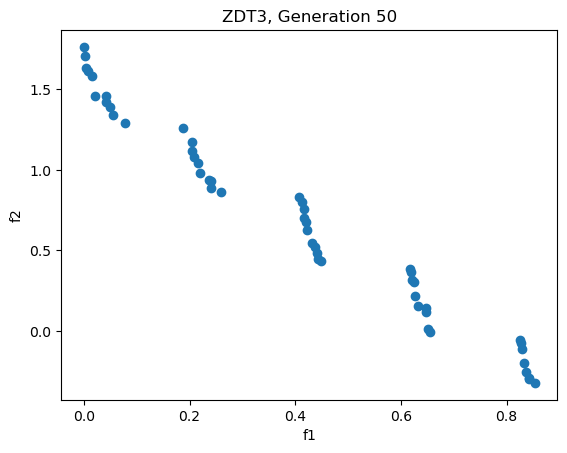

In [10]:
# Using the population records we can plot the final generation's objective functions
final_pop = generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[-1])]
plt.scatter(final_pop["f1"], final_pop["f2"])
plt.xlabel("f1")
plt.ylabel("f2")
plt.title(f"ZDT3, Generation {generator.n_generations}")

# File Output from Generator
In this section, we will take a look at the files which can be automatically written by the optimizer. We will create a temporary directory and clean it up at the end of this notebook.

The output files are the following.
 - `data.csv`: All data evaluated during the optimization
 - `populations.csv`: Each population is written here with a column `xopt_generation` to distinguish which generation the row belongs to
 - `checkpoints`: This generator periodically saves its full state to timestamped files in this directory

In [11]:
# Setup our output directory
output_dir = tempfile.mkdtemp()
print(f"Will write data to \"{output_dir}\"")

Will write data to "C:\Users\chris\AppData\Local\Temp\tmpg9bmbkbw"


In [12]:
# Set up a generator configured to output data
generator = NSGA2Generator(
    vocs=prob_vocs,
    output_dir=output_dir,  # Where will we write data
    checkpoint_freq=8,  # How often (in terms of generations) should we save the optimizer state?
)

# Run it for a couple of generations
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

In [13]:
# Check out the generated files
print(f"\"{output_dir}\": {os.listdir(output_dir)}")
checkpoint_dir = os.path.join(output_dir, "checkpoints")
print(f"\"checkpoints\": {os.listdir(checkpoint_dir)}")

"C:\Users\chris\AppData\Local\Temp\tmpg9bmbkbw": ['checkpoints', 'data.csv', 'populations.csv']
"checkpoints": ['20250302_184042_1.txt', '20250302_184042_2.txt', '20250302_184043_1.txt', '20250302_184043_2.txt']


In [14]:
# In the event data was already written to `output_dir` the generator will choose a new path with a numeric suffix
# to avoid overwriting anything.
X = Xopt(generator=NSGA2Generator(vocs=prob_vocs, output_dir=output_dir), evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

# Compare the requested path and where the data ended up
print(f"Requested path: \"{output_dir}\"")
print(f"Path used:      \"{X.generator.output_dir}\"")

Requested path: "C:\Users\chris\AppData\Local\Temp\tmpg9bmbkbw"
Path used:      "C:\Users\chris\AppData\Local\Temp\tmpg9bmbkbw_2"


In [15]:
# Load all data back in
df = pd.read_csv(os.path.join(generator.output_dir, "data.csv"))
df.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.036818,0.083992,0.039079,0.740742,0.165495,0.099685,0.650382,0.234728,0.517212,0.696031,...,0.523326,0.366041,0.026429,0,0,0.036818,4.185050,4.631710,0.000034,False
1,0.045461,0.663337,0.966569,0.089187,0.426997,0.426680,0.611599,0.820228,0.276461,0.381316,...,0.962302,0.795851,0.902969,0,37,0.045461,5.269874,5.829679,0.000011,False
2,0.122390,0.303373,0.978504,0.472530,0.397227,0.222816,0.252878,0.206580,0.154511,0.645002,...,0.366914,0.654315,0.141284,0,29,0.122390,4.661269,5.394665,0.000009,False
3,0.152292,0.950211,0.404490,0.820481,0.972610,0.378324,0.584300,0.713670,0.547461,0.762661,...,0.087926,0.813333,0.024669,0,8,0.152292,4.916887,5.696395,0.000008,False
4,0.162339,0.128090,0.097991,0.157542,0.967328,0.061113,0.429147,0.038471,0.047997,0.149773,...,0.430622,0.472947,0.797719,0,36,0.162339,3.933658,4.652428,0.000008,False


In [16]:
# Load the populations and get just the last population
df = pd.read_csv(os.path.join(generator.output_dir, "populations.csv"))
last_pop = df[df["xopt_generation"] == df["xopt_generation"].max()]
last_pop.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error,xopt_generation
1550,0.853033,0.025416,0.089123,0.113220,0.206249,0.044866,0.177340,0.051215,0.067991,0.073084,...,0.068271,0.057855,31,1596,0.853033,-0.229436,1.889194,0.000008,False,32
1551,0.000046,0.014795,0.070920,0.101654,0.140254,0.086294,0.062296,0.042035,0.091339,0.077255,...,0.077727,0.066449,31,1595,0.000046,1.842288,1.851477,0.000028,False,32
1552,0.225182,0.018623,0.026721,0.089675,0.074037,0.149040,0.157808,0.050536,0.129844,0.002747,...,0.076235,0.109150,30,1537,0.225182,1.040808,1.845611,0.000008,False,32
1553,0.063003,0.016389,0.062575,0.114740,0.080839,0.130621,0.156318,0.050805,0.104734,0.004087,...,0.075283,0.073073,31,1583,0.063003,1.427076,1.823877,0.000008,False,32
1554,0.827071,0.025206,0.075799,0.105539,0.224153,0.045255,0.311118,0.054923,0.040495,0.102429,...,0.074792,0.138530,26,1330,0.827071,0.093458,2.001764,0.000008,False,32


In [17]:
# Reload the optimizer from its last checkpoint
# NOTE: the vocs object is not retained with the checkpoint and should be added as in the following code
last_checkpoint = os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[-1])
with open(last_checkpoint) as f:
    restored_generator = NSGA2Generator.from_dict({"vocs": prob_vocs, **json.load(f)})
print(f"From file: {restored_generator}")

# Demonstrate using the generator after loading (starting optimization from its last saved point)
X = Xopt(generator=restored_generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()
print(f"Further optimization: {restored_generator}")

From file: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=32, fevals=1600)
Further optimization: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=64, fevals=3200)


In [18]:
# Clean up the output directory
shutil.rmtree(output_dir)